In [7]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti 
import gif_your_nifti.core as gif2nif


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-620bi9tm
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-620bi9tm
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6632 sha256=8df0a101aa134988530459cf4f658fc576323bc3a62106fef62a62a4552342da
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1eyg803/wheels/de/6d/35/5b931fbea2039fbd2ac937828c719c3cdd70953235af24b9ab
Successfully built gif_your_nifti


2025-09-28 02:06:09.502835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759025169.763016      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759025169.841817      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [10]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00:00:0100:01
  Attempting unins

In [12]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import shutil
import gdown
import nibabel as nib

# 1) Prepare
os.makedirs("data", exist_ok=True)
url = "https://drive.google.com/file/d/1ZEv2pBvxD8zvcCsNF_a2FdoM_nVQEWHB/view?usp=drive_link"

# 2) Download. If output is a directory, gdown will save using the original filename inside it.
download_path = gdown.download(url=url, output="data", fuzzy=True)  # returns the saved file path
print(f"Downloaded to: {download_path}")

# 3) If it's a .zip, extract it into data/
if download_path and download_path.lower().endswith(".zip"):
    print("Archive detected (.zip). Extracting...")
    shutil.unpack_archive(download_path, "data")
    print("Extracted to: data/")

# 4) If it’s a NIfTI file, load it directly with nibabel (no extraction needed)
# Adjust the path if your file is a .nii/.nii.gz after download or after extraction.
def try_load_nifti(path):
    try:
        img = nib.load(path)
        arr = img.get_fdata()
        print(f"Loaded NIfTI shape: {arr.shape}")
        return arr
    except Exception as e:
        print(f"Not a NIfTI or load failed for {path}: {e}")

# If the file is a NIfTI already:
if download_path and (download_path.lower().endswith(".nii") or download_path.lower().endswith(".nii.gz")):
    _ = try_load_nifti(download_path)
else:
    # If it was a zip, scan data/ for NIfTI files and load one example
    for root, _, files in os.walk("data"):
        for f in files:
            if f.lower().endswith((".nii", ".nii.gz")):
                nifti_path = os.path.join(root, f)
                print(f"Found NIfTI: {nifti_path}")
                _ = try_load_nifti(nifti_path)
                break
        else:
            continue
        break

Downloading...
From (original): https://drive.google.com/uc?id=1ZEv2pBvxD8zvcCsNF_a2FdoM_nVQEWHB
From (redirected): https://drive.google.com/uc?id=1ZEv2pBvxD8zvcCsNF_a2FdoM_nVQEWHB&confirm=t&uuid=e73558d0-3bbd-404c-8426-5f26df4a2e98
To: /kaggle/working/data
100%|██████████| 3.26G/3.26G [00:31<00:00, 105MB/s] 

Downloaded to: data


In [15]:
import os, shutil, glob

base = "data"
print("Listing data/:")
for root, dirs, files in os.walk(base):
    level = root.replace(base, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files:
        print(f"{subindent}{f}")
    # Limit deep prints to avoid huge logs
    if level > 3:
        break

# Auto-extract any .zip files found
zips = glob.glob(os.path.join(base, "**", "*.zip"), recursive=True)
for z in zips:
    print(f"Extracting: {z}")
    extract_to = os.path.dirname(z)
    shutil.unpack_archive(z, extract_to)
    print(f"Extracted under: {extract_to}")

Listing data/:
data/
  data19kifl7r.part


In [16]:
import os
import glob
import shutil
import gdown

# Prepare
os.makedirs("data", exist_ok=True)

# Remove any previous partial/unknown files to avoid confusion
for f in glob.glob("data/*"):
    try:
        os.remove(f)
    except IsADirectoryError:
        shutil.rmtree(f)

# Your public Drive file link
url = "https://drive.google.com/file/d/1ZEv2pBvxD8zvcCsNF_a2FdoM_nVQEWHB/view?usp=drive_link"

# Re-download with a clear filename (change to .zip if you know it’s an archive)
target_path = "data/brats_download"  # we’ll detect the type below
saved_path = gdown.download(url=url, output=target_path, fuzzy=True, quiet=False)
print("Downloaded to:", saved_path)

Downloading...
From (original): https://drive.google.com/uc?id=1ZEv2pBvxD8zvcCsNF_a2FdoM_nVQEWHB
From (redirected): https://drive.google.com/uc?id=1ZEv2pBvxD8zvcCsNF_a2FdoM_nVQEWHB&confirm=t&uuid=6c2ab185-e86f-4829-aa88-7fa8e0087d00
To: /kaggle/working/data/brats_download
100%|██████████| 3.26G/3.26G [00:35<00:00, 91.8MB/s]

Downloaded to: data/brats_download


In [17]:
import os, glob, shutil

base = "data"
os.makedirs(base, exist_ok=True)

print("=== Listing data/ ===")
for root, _, files in os.walk(base):
    level = root.replace(base, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root) or 'data'}/")
    for f in files:
        print(f"{indent}  {f}")
    if level > 3:
        break

# Find all non-directory items directly under data/ first; if none, search deep
candidates = [os.path.join(base, f) for f in os.listdir(base) if os.path.isfile(os.path.join(base, f))]
if not candidates:
    candidates = glob.glob(os.path.join(base, "**", "*"), recursive=True)
    candidates = [p for p in candidates if os.path.isfile(p)]

if not candidates:
    raise FileNotFoundError("No files found under data/. Please re-run the download step or share the output above.")

# Prefer the largest file (likely the payload)
target = max(candidates, key=lambda p: os.path.getsize(p))
size_mb = os.path.getsize(target) / (1024 * 1024)
print(f"\nSelected file: {target} ({size_mb:.2f} MB)")

def is_zip(path):
    try:
        with open(path, "rb") as f:
            return f.read(4) == b"PK\x03\x04"
    except Exception:
        return False

def is_gzip(path):
    try:
        with open(path, "rb") as f:
            return f.read(2) == b"\x1f\x8b"
    except Exception:
        return False

def ensure_extension(path):
    # If it lacks an extension, add one based on magic bytes
    base_no_ext, ext = os.path.splitext(path)
    if ext.lower() in [".zip", ".nii", ".gz", ".nii.gz"]:
        return path
    if is_zip(path):
        new = path + ".zip"
        os.rename(path, new)
        print(f"Renamed -> {new}")
        return new
    if is_gzip(path):
        # could be .nii.gz; keep generic .gz first
        new = path + ".nii.gz"
        os.rename(path, new)
        print(f"Renamed -> {new}")
        return new
    return path

target = ensure_extension(target)

# Process based on type
if target.lower().endswith(".zip"):
    print("Detected ZIP archive. Extracting...")
    extract_dir = os.path.dirname(target)
    shutil.unpack_archive(target, extract_dir)
    print(f"Extracted under: {extract_dir}")

    # Find NIfTI files post extraction
    nii_files = glob.glob(os.path.join(base, "**", "*.nii"), recursive=True) + \
                glob.glob(os.path.join(base, "**", "*.nii.gz"), recursive=True)
    if nii_files:
        print(f"Found {len(nii_files)} NIfTI files. Examples:")
        for p in nii_files[:5]:
            print(" -", p)
    else:
        print("No NIfTI files found after extraction. Please share the listing above.")

elif target.lower().endswith(".nii") or target.lower().endswith(".nii.gz"):
    print("Detected NIfTI file. Attempting to load...")
    import nibabel as nib
    try:
        img = nib.load(target)
        arr = img.get_fdata()
        print(f"Loaded NIfTI OK: shape={arr.shape}")
    except Exception as e:
        print(f"Failed to load NIfTI: {e}")
else:
    print("Unknown file type. If this is meant to be a zip, add .zip and re-run. If NIfTI, add .nii.gz and re-run.")

=== Listing data/ ===
data/
  brats_download

Selected file: data/brats_download (3110.09 MB)
Renamed -> data/brats_download.zip
Detected ZIP archive. Extracting...


OSError: [Errno 28] No space left on device

In [20]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    NormalizeIntensityd, CropForegroundd, RandCropByPosNegLabeld,
    RandFlipd, RandRotated, RandZoomd, RandGaussianNoised,
    EnsureTyped
)

# Train 3D on two modalities to save VRAM (FLAIR + T1CE)
keys_img = ["flair", "t1ce"]
keys_all = keys_img + ["seg"]

# For ~5 GiB VRAM; lower to (64,64,64) if you hit OOM
roi_size = (80, 80, 80)

train_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    Orientationd(keys=keys_all, axcodes="RAS"),

    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),

    # Sample small 3D patches, balanced between tumor and background
    RandCropByPosNegLabeld(
        keys=keys_all,
        label_key="seg",
        spatial_size=roi_size,
        pos=1, neg=1, num_samples=2,
        image_key="flair",
    ),

    # Conservative augmentations
    RandFlipd(keys=keys_all, prob=0.3, spatial_axis=[0, 1, 2]),
    RandRotated(
        keys=keys_all,
        range_x=0.26, range_y=0.26, range_z=0.26,  # ~15 degrees
        prob=0.2,
        mode=("bilinear", "bilinear", "nearest"),  # labels use nearest
        padding_mode="border",
    ),
    RandZoomd(
        keys=keys_all,
        min_zoom=0.9, max_zoom=1.1,
        prob=0.2,
        mode=("bilinear", "bilinear", "nearest"),
        keep_size=True,
    ),
    RandGaussianNoised(keys=keys_img, prob=0.15, mean=0.0, std=0.01),

    EnsureTyped(keys=keys_all),
])

val_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    Orientationd(keys=keys_all, axcodes="RAS"),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    EnsureTyped(keys=keys_all),
])

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [25]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    NormalizeIntensityd, CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, EnsureTyped
)

# Two modalities to save VRAM
keys_img = ["flair", "t1ce"]
keys_all = keys_img + ["seg"]

# Use a small ROI for ~5 GiB VRAM. If OOM, try (64, 64, 64).
roi_size = (80, 80, 80)

train_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    # Deterministic intensity normalization
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    # Deterministic crop to remove empty background
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    # Deterministic shaping to a fixed patch size
    SpatialPadd(keys=keys_all, spatial_size=roi_size),      # pad if smaller
    CenterSpatialCropd(keys=keys_all, roi_size=roi_size),   # center-crop to ROI
    # SINGLE augmentation: random flips (fast)
    RandFlipd(keys=keys_all, prob=0.3, spatial_axis=[0, 1, 2]),
    EnsureTyped(keys=keys_all),
])

val_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    SpatialPadd(keys=keys_all, spatial_size=roi_size),
    CenterSpatialCropd(keys=keys_all, roi_size=roi_size),
    EnsureTyped(keys=keys_all),
])

In [26]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    NormalizeIntensityd, CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised,  # <- added
    EnsureTyped
)

keys_img = ["flair", "t1ce"]
keys_all = keys_img + ["seg"]

roi_size = (80, 80, 80)  # use (64,64,64) if you hit OOM

train_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    SpatialPadd(keys=keys_all, spatial_size=roi_size),
    CenterSpatialCropd(keys=keys_all, roi_size=roi_size),
    RandFlipd(keys=keys_all, prob=0.3, spatial_axis=[0, 1, 2]),      # existing simple aug
    RandGaussianNoised(keys=keys_img, prob=0.15, mean=0.0, std=0.01), # new simple aug
    EnsureTyped(keys=keys_all),
])

val_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    SpatialPadd(keys=keys_all, spatial_size=roi_size),
    CenterSpatialCropd(keys=keys_all, roi_size=roi_size),
    EnsureTyped(keys=keys_all),
])

In [27]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    NormalizeIntensityd, CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised, RandScaleIntensityd,  # <- added RandScaleIntensityd
    EnsureTyped
)

In [28]:
# Modalities to use (keeps memory low)
keys_img = ["flair", "t1ce"]
keys_all = keys_img + ["seg"]

# ROI tuned for ~5 GiB VRAM; reduce to (64,64,64) if needed
roi_size = (80, 80, 80)

train_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),

    # Deterministic preprocessing
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    SpatialPadd(keys=keys_all, spatial_size=roi_size),
    CenterSpatialCropd(keys=keys_all, roi_size=roi_size),

    # Simple augmentations (fast, stable)
    RandFlipd(keys=keys_all, prob=0.3, spatial_axis=[0, 1, 2]),
    RandGaussianNoised(keys=keys_img, prob=0.15, mean=0.0, std=0.01),
    RandScaleIntensityd(keys=keys_img, factors=0.1, prob=0.15),  # scales by ~±10%

    EnsureTyped(keys=keys_all),
])

val_transforms = Compose([
    LoadImaged(keys=keys_all),
    EnsureChannelFirstd(keys=keys_all),
    NormalizeIntensityd(keys=keys_img, nonzero=True, channel_wise=True),
    CropForegroundd(keys=keys_all, source_key="flair", margin=8),
    SpatialPadd(keys=keys_all, spatial_size=roi_size),
    CenterSpatialCropd(keys=keys_all, roi_size=roi_size),
    EnsureTyped(keys=keys_all),
])

In [29]:
%pip install -q monai nibabel torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [30]:
import torch, monai
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
print("monai:", monai.__version__)

torch: 2.6.0+cu124 | cuda: True
monai: 1.5.1


In [31]:
import os, glob, torch, numpy as np
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    NormalizeIntensityd, CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised, RandScaleIntensityd,
    EnsureTyped
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism

# ====== CONFIG (tuned for ~5 GiB VRAM) ======
set_determinism(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_ROOT = "data"          # change if your dataset is elsewhere
IMG_KEYS = ["flair", "t1ce"]
ALL_KEYS = IMG_KEYS + ["seg"]

ROI_SIZE = (64, 64, 64)     # smaller to fit comfortably
MAX_TRAIN_CASES = 30
MAX_VAL_CASES   = 5

DL_NUM_WORKERS = 1
DL_PIN_MEMORY = torch.cuda.is_available()
DL_PERSISTENT = False

UNET_CHANNELS = (16, 32, 64)  # small model
UNET_STRIDES  = (2, 2)
MAX_EPOCHS    = 25
VAL_EVERY     = 2
PATIENCE      = 6

# ====== TRANSFORMS (3 simple augs) ======
train_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),
    NormalizeIntensityd(keys=IMG_KEYS, nonzero=True, channel_wise=True),
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),
    RandFlipd(keys=ALL_KEYS, prob=0.3, spatial_axis=[0, 1, 2]),
    RandGaussianNoised(keys=IMG_KEYS, prob=0.15, mean=0.0, std=0.01),
    RandScaleIntensityd(keys=IMG_KEYS, factors=0.1, prob=0.15),
    EnsureTyped(keys=ALL_KEYS),
])

val_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),
    NormalizeIntensityd(keys=IMG_KEYS, nonzero=True, channel_wise=True),
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),
    EnsureTyped(keys=ALL_KEYS),
])

# ====== DATA DISCOVERY ======
def build_case_list(root: str):
    flair_paths = glob.glob(os.path.join(root, "**", "*_flair.nii.gz"), recursive=True)
    flair_paths += glob.glob(os.path.join(root, "**", "*_flair.nii"), recursive=True)
    cases = []
    for fpath in sorted(flair_paths):
        case_dir = os.path.dirname(fpath)
        base = os.path.basename(case_dir)
        t1ce = os.path.join(case_dir, f"{base}_t1ce.nii.gz")
        if not os.path.exists(t1ce): t1ce = os.path.join(case_dir, f"{base}_t1ce.nii")
        seg  = os.path.join(case_dir, f"{base}_seg.nii.gz")
        if not os.path.exists(seg):  seg  = os.path.join(case_dir, f"{base}_seg.nii")
        if os.path.exists(t1ce) and os.path.exists(seg):
            cases.append({"flair": fpath, "t1ce": t1ce, "seg": seg})
    return cases

all_cases = build_case_list(DATA_ROOT)
print(f"Found cases: {len(all_cases)} under '{DATA_ROOT}'")

train_files = all_cases[:MAX_TRAIN_CASES]
val_files   = all_cases[MAX_TRAIN_CASES:MAX_TRAIN_CASES + MAX_VAL_CASES]
print(f"Train: {len(train_files)} | Val: {len(val_files)}")

if len(train_files) == 0:
    raise SystemExit("No training cases found. Ensure your dataset is under 'data/' with BraTS-style names.")

# ====== LOADERS ======
train_ds = Dataset(train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True,
    num_workers=DL_NUM_WORKERS, pin_memory=DL_PIN_MEMORY, persistent_workers=DL_PERSISTENT
)

val_loader = None
if len(val_files) > 0:
    val_ds = Dataset(val_files, transform=val_transforms)
    val_loader = DataLoader(
        val_ds, batch_size=1, shuffle=False,
        num_workers=DL_NUM_WORKERS, pin_memory=DL_PIN_MEMORY, persistent_workers=DL_PERSISTENT
    )

# ====== MODEL / OPTIM / LOSS / METRICS ======
model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=4,       # adjust to your labels if different
    channels=UNET_CHANNELS,
    strides=UNET_STRIDES,
    num_res_units=2,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")
scaler = torch.cuda.amp.GradScaler()

# ====== TRAINING LOOP ======
best_dice = 0.0
bad_epochs = 0

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device)  # (B,2,H,W,D)
        seg  = batch["seg"].to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss = loss_fn(logits, seg)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))

    val_dice = 0.0
    do_val = val_loader is not None and (epoch % VAL_EVERY == 0)
    if do_val:
        model.eval()
        dice_metric.reset()
        with torch.no_grad(), torch.cuda.amp.autocast():
            for batch in val_loader:
                imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device)
                seg  = batch["seg"].to(device)
                pred = sliding_window_inference(
                    imgs, roi_size=ROI_SIZE, sw_batch_size=1, predictor=model, overlap=0.25
                )
                dice_metric(y_pred=torch.softmax(pred, dim=1), y=seg)
        val_dice = dice_metric.aggregate().item()

    print(f"Epoch {epoch:02d} | TrainLoss {avg_loss:.4f} | ValDice {val_dice:.4f}")

    improved = (do_val and val_dice > best_dice) or (not do_val and epoch == 1)
    if improved:
        best_dice = max(best_dice, val_dice)
        bad_epochs = 0
        torch.save(model.state_dict(), "best_3d_unet.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("Early stopping.")
            break

print("Done. Best Val Dice:", best_dice)
print("Best model saved to best_3d_unet.pth")

Found cases: 212 under 'data'
Train: 30 | Val: 5


/tmp/ipykernel_36/4168587825.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_36/4168587825.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [32]:
import os, glob, torch
from monai.data import Dataset, DataLoader

# Assumes you already defined:
# DATA_ROOT, train_transforms, val_transforms, ROI_SIZE, IMG_KEYS, ALL_KEYS

def build_case_list(root: str):
    flairs = glob.glob(os.path.join(root, "**", "*_flair.nii.gz"), recursive=True)
    flairs += glob.glob(os.path.join(root, "**", "*_flair.nii"), recursive=True)
    cases = []
    for fpath in sorted(flairs):
        d = os.path.dirname(fpath)
        base = os.path.basename(d)
        t1ce = os.path.join(d, f"{base}_t1ce.nii.gz")
        if not os.path.exists(t1ce): t1ce = os.path.join(d, f"{base}_t1ce.nii")
        seg  = os.path.join(d, f"{base}_seg.nii.gz")
        if not os.path.exists(seg):  seg  = os.path.join(d, f"{base}_seg.nii")
        if os.path.exists(t1ce) and os.path.exists(seg):
            cases.append({"flair": fpath, "t1ce": t1ce, "seg": seg})
    return cases

DATA_ROOT = "data"  # change if needed
all_cases = build_case_list(DATA_ROOT)
train_files = all_cases[:30]
val_files   = all_cases[30:35]
print(f"Train: {len(train_files)} | Val: {len(val_files)}")

train_ds = Dataset(train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, pin_memory=torch.cuda.is_available())

val_loader = None
if len(val_files) > 0:
    val_ds = Dataset(val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=torch.cuda.is_available())

Train: 30 | Val: 5


Displaying 10 augmented training patch(es) inline...


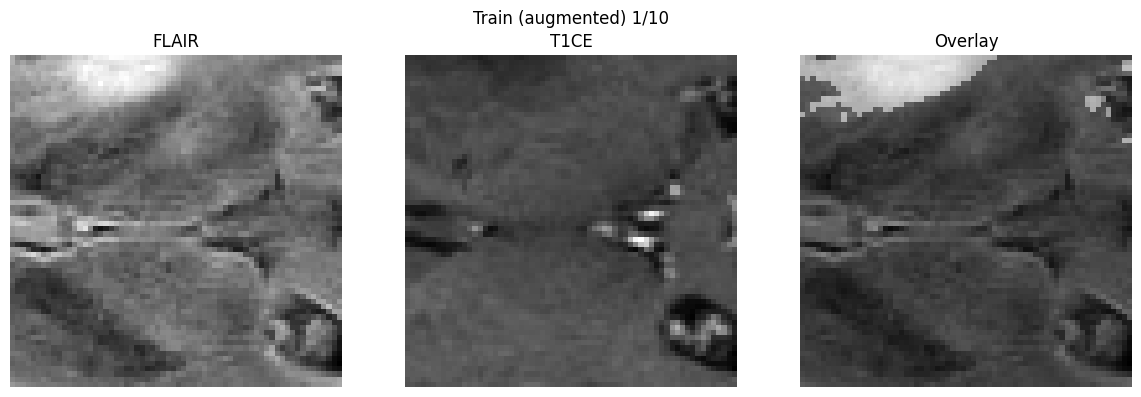

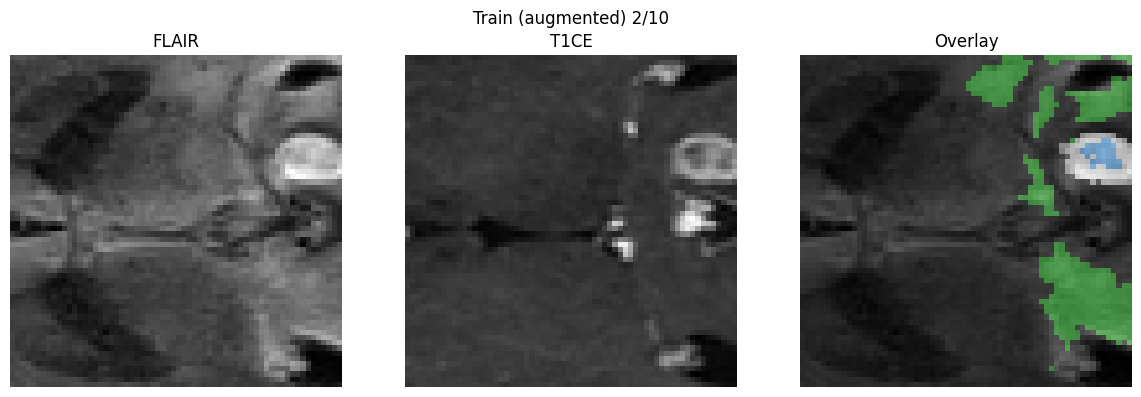

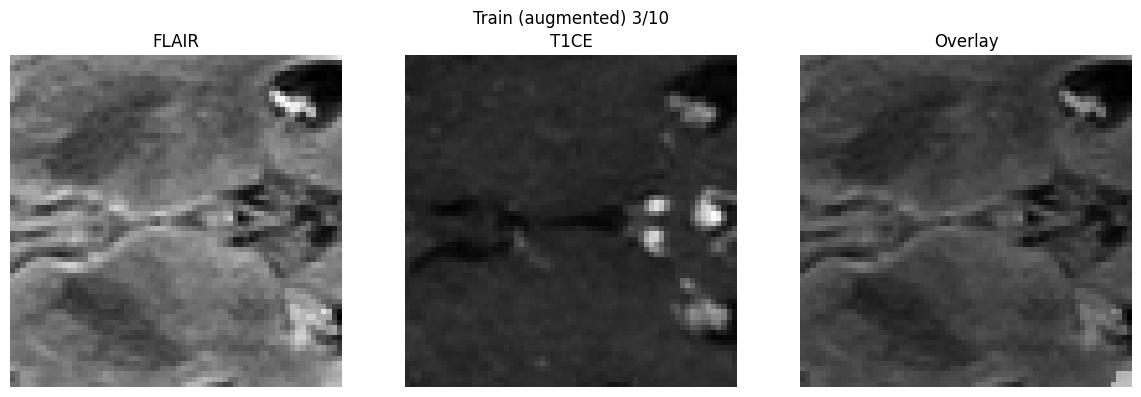

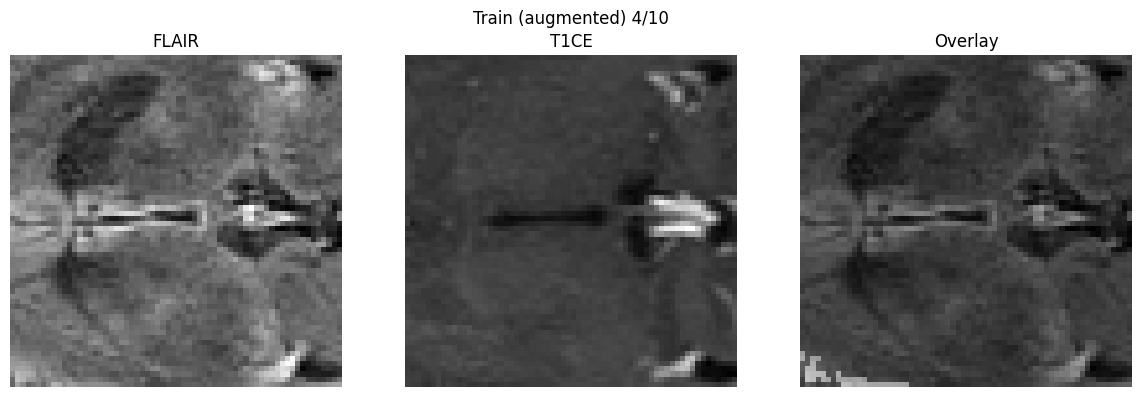

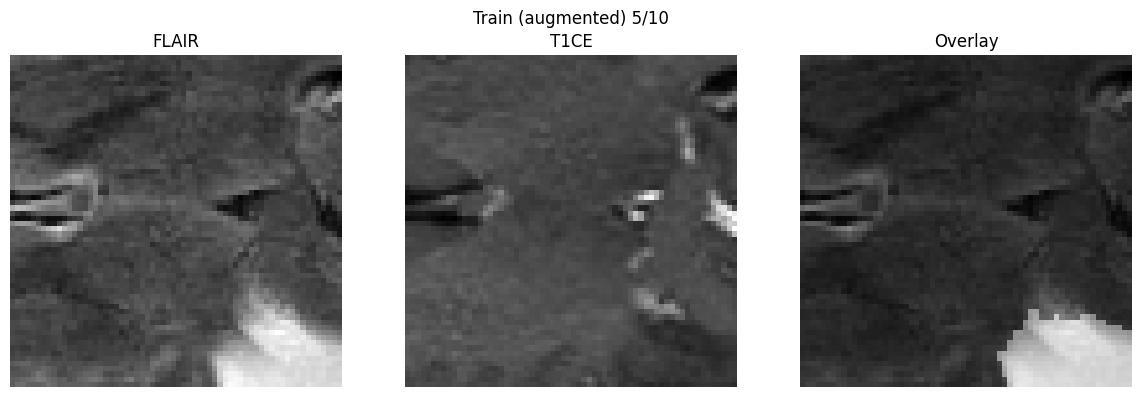

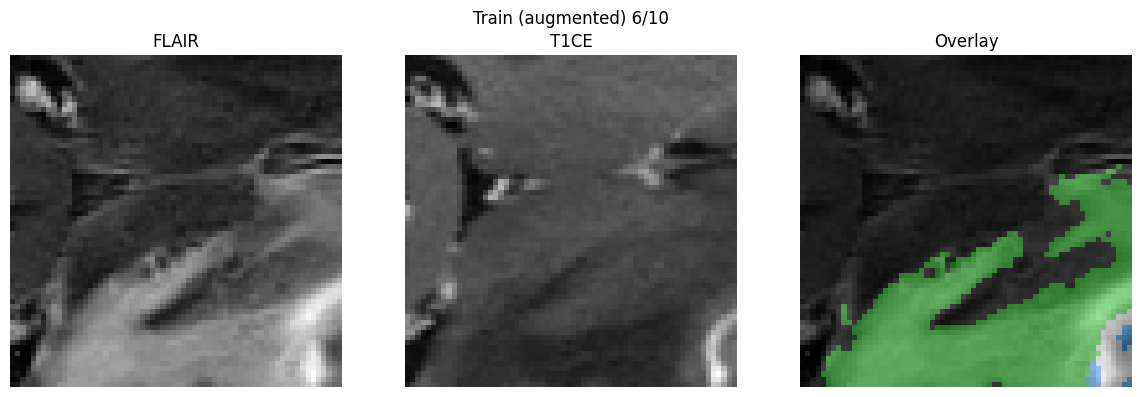

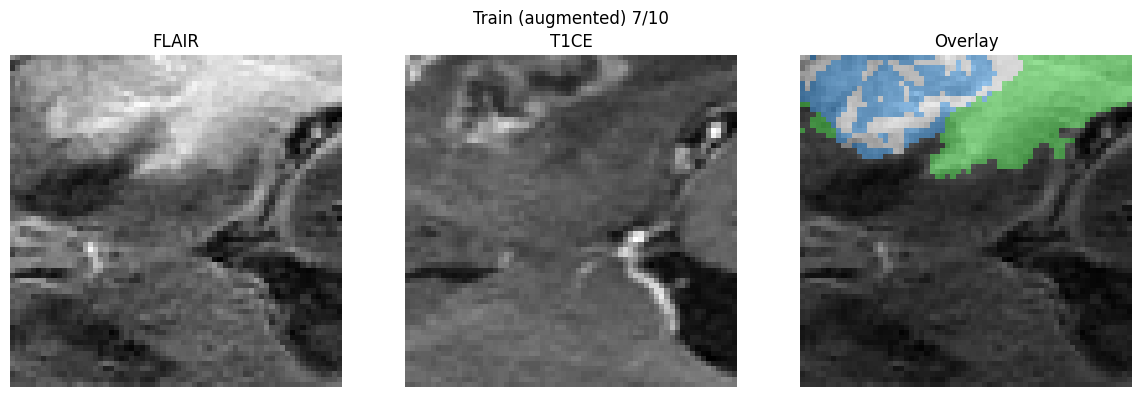

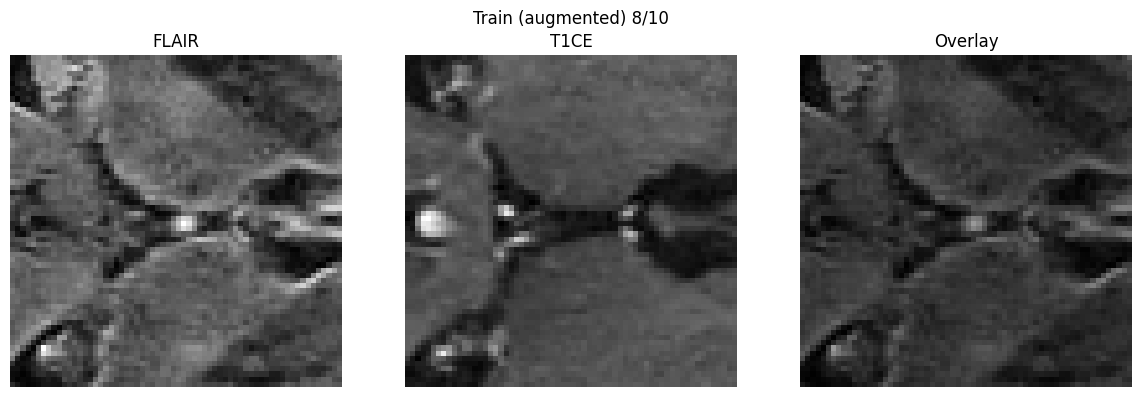

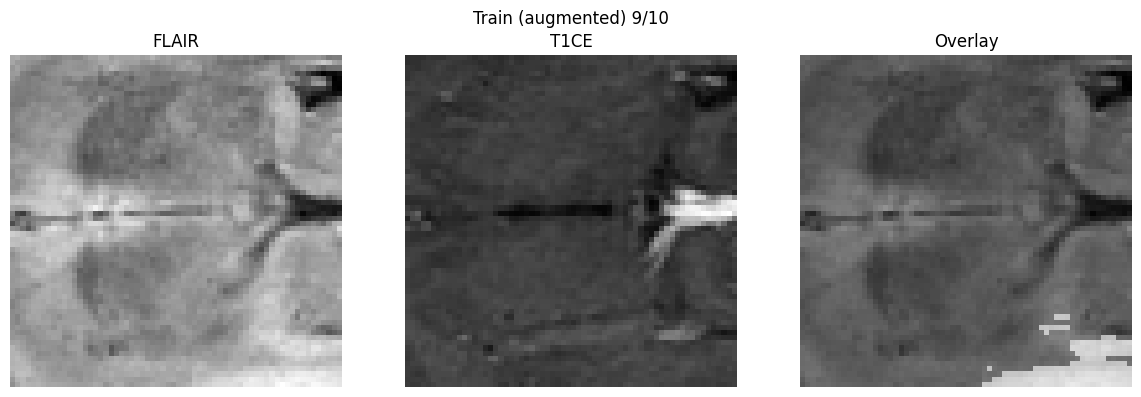

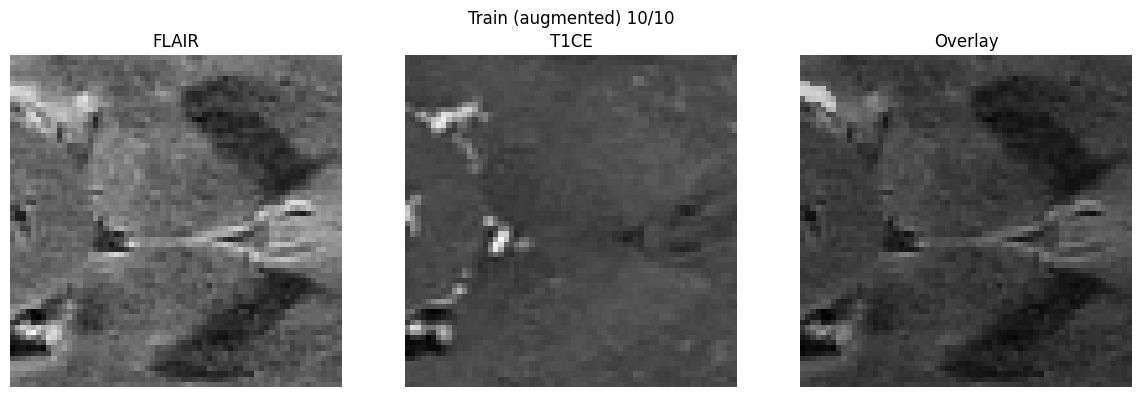

Displaying 5 validation patch(es) inline...


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 41, in do_one_step
    data = pin_memory(data, device)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 75, in pin_memory
    {k: pin_memory(sample, device) for k, sample in data.items()}
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 75, in <dictcomp>
    {k: pin_memory(sample, device) for k, sample in data.items()}
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 64, in pin_memory
    return data.pin_memory(device)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/monai/data/meta_tensor.py", line 283, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 1648, in __torch_function__
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [34]:
import matplotlib.pyplot as plt
import torch

def show_batch_center_slice_inline(batch, title=""):
    flair = batch["flair"][0, 0].cpu().numpy()
    t1ce  = batch["t1ce"][0, 0].cpu().numpy()
    seg   = batch["seg"][0, 0].cpu().numpy()
    z = flair.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(flair[:, :, z], cmap="gray"); axs[0].set_title("FLAIR"); axs[0].axis("off")
    axs[1].imshow(t1ce[:, :, z],  cmap="gray"); axs[1].set_title("T1CE");  axs[1].axis("off")
    axs[2].imshow(flair[:, :, z], cmap="gray")
    axs[2].imshow(seg[:, :, z], cmap="nipy_spectral", alpha=0.4, interpolation="nearest")
    axs[2].set_title("Overlay"); axs[2].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

# Show up to 10 augmented training patches inline (no saving)
if 'train_loader' in globals():
    it_train = iter(train_loader)
    n_train_vis = min(10, len(train_loader.dataset))
    print(f"Displaying {n_train_vis} augmented training patch(es) inline...")
    for i in range(n_train_vis):
        try:
            batch = next(it_train)
            show_batch_center_slice_inline(batch, title=f"Train (augmented) {i+1}/{n_train_vis}")
        except StopIteration:
            break
else:
    print("train_loader not found. Build loaders first.")

# Show up to 5 validation patches inline (deterministic)
if 'val_loader' in globals() and val_loader is not None:
    it_val = iter(val_loader)
    n_val_vis = min(5, len(val_loader.dataset))
    print(f"Displaying {n_val_vis} validation patch(es) inline...")
    for i in range(n_val_vis):
        try:
            batch = next(it_val)
            show_batch_center_slice_inline(batch, title=f"Validation (deterministic) {i+1}/{n_val_vis}")
        except StopIteration:
            break
else:
    print("val_loader not available or empty.")

In [36]:
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    NormalizeIntensityd, CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised, RandScaleIntensityd,
    MapLabelValued, EnsureTyped
)

IMG_KEYS = ["flair", "t1ce"]
ALL_KEYS = IMG_KEYS + ["seg"]
ROI_SIZE = (64, 64, 64)

label_remap = MapLabelValued(keys="seg", orig_labels=[4], target_labels=[3])

# For VISIBILITY (temporary): higher probs. After confirming, reduce back to prob=0.3/0.15.
train_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),
    NormalizeIntensityd(keys=IMG_KEYS, nonzero=True, channel_wise=True),
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),
    label_remap,
    # Augmentations (train only)
    RandFlipd(keys=ALL_KEYS, prob=0.7, spatial_axis=[0, 1, 2]),
    RandGaussianNoised(keys=IMG_KEYS, prob=0.5, mean=0.0, std=0.01),
    RandScaleIntensityd(keys=IMG_KEYS, factors=0.1, prob=0.5),
    EnsureTyped(keys=ALL_KEYS, dtype={"flair": torch.float32, "t1ce": torch.float32, "seg": torch.long}),
])

val_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),
    NormalizeIntensityd(keys=IMG_KEYS, nonzero=True, channel_wise=True),
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),
    label_remap,
    EnsureTyped(keys=ALL_KEYS, dtype={"flair": torch.float32, "t1ce": torch.float32, "seg": torch.long}),
])

In [38]:
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    NormalizeIntensityd, CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised, RandScaleIntensityd,
    MapLabelValued, EnsureTyped
)

IMG_KEYS = ["flair", "t1ce"]
ALL_KEYS = IMG_KEYS + ["seg"]
ROI_SIZE = (64, 64, 64)

# Remap BraTS label 4 -> 3 so classes = {0,1,2,3}
label_remap = MapLabelValued(keys="seg", orig_labels=[4], target_labels=[3])

# For visible verification, you can temporarily use higher probs (then dial back)
train_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),

    NormalizeIntensityd(keys=IMG_KEYS, nonzero=True, channel_wise=True),
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),

    label_remap,

    # Train-time augmentations
    RandFlipd(keys=ALL_KEYS, prob=0.7, spatial_axis=[0, 1, 2]),
    RandGaussianNoised(keys=IMG_KEYS, prob=0.5, mean=0.0, std=0.01),
    RandScaleIntensityd(keys=IMG_KEYS, factors=0.1, prob=0.5),

    # Correct dtype usage (separate calls)
    EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
    EnsureTyped(keys="seg", dtype=torch.long),
])

val_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),

    NormalizeIntensityd(keys=IMG_KEYS, nonzero=True, channel_wise=True),
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),

    label_remap,

    EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
    EnsureTyped(keys="seg", dtype=torch.long),
])

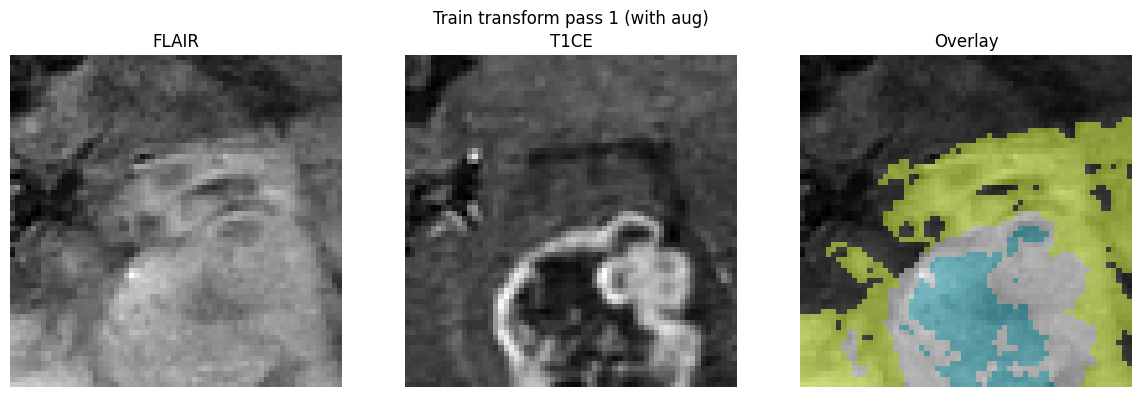

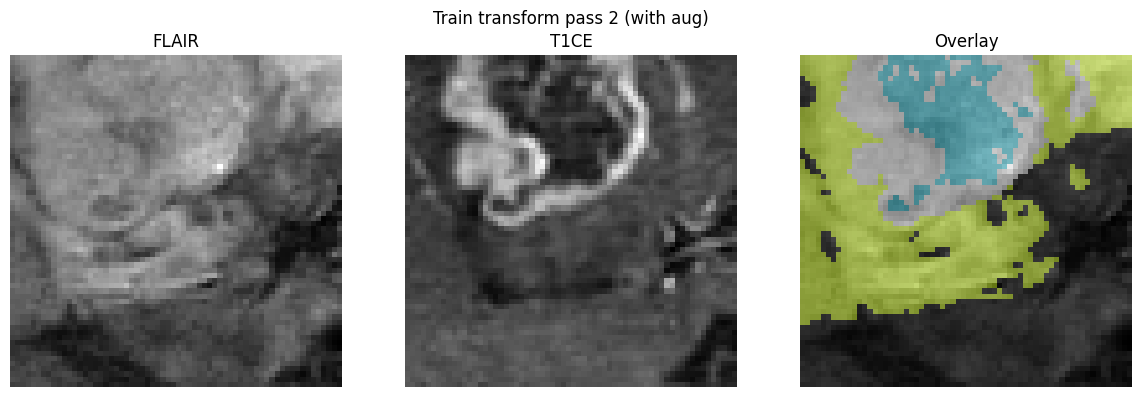

Aug1: flair mean=0.5975, std=1.2625
Aug2: flair mean=0.5437, std=1.1488


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Use an existing training record
sample_rec = train_files[0]  # assumes train_files already built

aug1 = train_transforms(sample_rec.copy())
aug2 = train_transforms(sample_rec.copy())

def show_triplet(sample, title):
    flair = sample["flair"][0].cpu().numpy()  # (H,W,D)
    t1ce  = sample["t1ce"][0].cpu().numpy()
    seg   = sample["seg"][0].cpu().numpy().astype(np.int32)
    z = flair.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(flair[:, :, z], cmap="gray"); axs[0].set_title("FLAIR"); axs[0].axis("off")
    axs[1].imshow(t1ce[:, :, z],  cmap="gray"); axs[1].set_title("T1CE"); axs[1].axis("off")
    axs[2].imshow(flair[:, :, z], cmap="gray")
    axs[2].imshow(seg[:, :, z], cmap="nipy_spectral", alpha=0.4, interpolation="nearest")
    axs[2].set_title("Overlay"); axs[2].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

show_triplet(aug1, "Train transform pass 1 (with aug)")
show_triplet(aug2, "Train transform pass 2 (with aug)")

# Simple stats to confirm intensity changes
def stats(tag, sample):
    x = sample["flair"][0].cpu().numpy()
    print(f"{tag}: flair mean={x.mean():.4f}, std={x.std():.4f}")
stats("Aug1", aug1)
stats("Aug2", aug2)

In [40]:
# Append-safe: redefine transforms and rebuild loaders in one go.

import os, glob, torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    ScaleIntensityRangePercentilesd,
    CropForegroundd,
    SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised, RandScaleIntensityd,
    MapLabelValued, EnsureTyped
)
from monai.data import Dataset, DataLoader

# Config (keep consistent with your training cell)
IMG_KEYS = ["flair", "t1ce"]
ALL_KEYS = IMG_KEYS + ["seg"]
ROI_SIZE = (64, 64, 64)
DATA_ROOT = "data"

# Label fix and intensity windowing
label_remap = MapLabelValued(keys="seg", orig_labels=[4], target_labels=[3])
intensity_window = ScaleIntensityRangePercentilesd(
    keys=IMG_KEYS, lower=0.5, upper=99.5, b_min=0.0, b_max=1.0, clip=True
)

# Transforms (train: soft augs; val: deterministic)
train_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),

    intensity_window,
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),

    label_remap,

    RandFlipd(keys=ALL_KEYS, prob=0.30, spatial_axis=[0, 1, 2]),
    RandGaussianNoised(keys=IMG_KEYS, prob=0.10, mean=0.0, std=0.003),
    RandScaleIntensityd(keys=IMG_KEYS, factors=0.05, prob=0.10),

    EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
    EnsureTyped(keys="seg", dtype=torch.long),
])

val_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),

    intensity_window,
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),

    label_remap,

    EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
    EnsureTyped(keys="seg", dtype=torch.long),
])

# Reuse train_files/val_files if already built; otherwise build now
def build_case_list(root: str):
    flairs = glob.glob(os.path.join(root, "**", "*_flair.nii.gz"), recursive=True)
    flairs += glob.glob(os.path.join(root, "**", "*_flair.nii"), recursive=True)
    cases = []
    for fpath in sorted(flairs):
        d = os.path.dirname(fpath)
        base = os.path.basename(d)
        t1ce = os.path.join(d, f"{base}_t1ce.nii.gz")
        if not os.path.exists(t1ce): t1ce = os.path.join(d, f"{base}_t1ce.nii")
        seg  = os.path.join(d, f"{base}_seg.nii.gz")
        if not os.path.exists(seg):  seg  = os.path.join(d, f"{base}_seg.nii")
        if os.path.exists(t1ce) and os.path.exists(seg):
            cases.append({"flair": fpath, "t1ce": t1ce, "seg": seg})
    return cases

if "train_files" not in globals() or "val_files" not in globals():
    all_cases = build_case_list(DATA_ROOT)
    train_files = all_cases[:30]
    val_files   = all_cases[30:35]

print(f"Train: {len(train_files)} | Val: {len(val_files)}")

# Rebuild datasets/loaders so new transforms take effect
train_ds = Dataset(train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True,
    num_workers=1, pin_memory=torch.cuda.is_available()
)

val_loader = None
if len(val_files) > 0:
    val_ds = Dataset(val_files, transform=val_transforms)
    val_loader = DataLoader(
        val_ds, batch_size=1, shuffle=False,
        num_workers=1, pin_memory=torch.cuda.is_available()
)
print("Loaders rebuilt with updated transforms.")

Train: 30 | Val: 5
Loaders rebuilt with updated transforms.


In [42]:
# SAFE TRAIN STARTER (no global CUDA seeding)
import os, random, numpy as np, torch
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optional: lightweight seeding (avoid touching CUDA RNG)
seed = 42
random.seed(seed)
np.random.seed(seed)
# DO NOT CALL torch.manual_seed or set_determinism here (caused your crash)

# Reuse ROI_SIZE defined earlier, or set fallback
ROI_SIZE = globals().get("ROI_SIZE", (64, 64, 64))

# Model: tiny UNet for low VRAM
model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=4,       # {0,1,2,3} after 4->3 remap
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")
scaler = torch.cuda.amp.GradScaler()

def voxel_accuracy(logits, targets):
    with torch.no_grad():
        pred = logits.argmax(dim=1, keepdim=True)
        return (pred == targets).float().mean().item()

MAX_EPOCHS = 12
PATIENCE    = 6
best_dice   = 0.0
bad_epochs  = 0

assert 'train_loader' in globals() and len(train_loader) > 0, "train_loader is empty. Rebuild loaders first."

for epoch in range(1, MAX_EPOCHS + 1):
    # Train
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device)
        seg  = batch["seg"].to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss = loss_fn(logits, seg)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))

    # Validate
    val_dice = 0.0
    val_acc  = 0.0
    if 'val_loader' in globals() and val_loader is not None and len(val_loader) > 0:
        model.eval()
        dice_metric.reset()
        acc_sum, n = 0.0, 0
        with torch.no_grad(), torch.cuda.amp.autocast():
            for batch in val_loader:
                imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device)
                seg  = batch["seg"].to(device)
                pred = sliding_window_inference(imgs, roi_size=ROI_SIZE, sw_batch_size=1, predictor=model, overlap=0.25)
                dice_metric(y_pred=torch.softmax(pred, dim=1), y=seg)
                acc_sum += voxel_accuracy(pred, seg)
                n += 1
        val_dice = dice_metric.aggregate().item()
        val_acc  = acc_sum / max(1, n)

    print(f"Epoch {epoch:02d} | TrainLoss {avg_loss:.4f} | ValDice {val_dice:.4f} | ValAcc {val_acc:.4f}")

    improved = (val_loader is not None and len(val_loader) > 0 and val_dice > best_dice) or (val_loader is None and epoch == 1)
    if improved:
        best_dice = max(best_dice, val_dice)
        bad_epochs = 0
        torch.save(model.state_dict(), "best_3d_unet.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("Early stopping.")
            break

print("Done. Best Val Dice:", best_dice)
print("Best model saved to best_3d_unet.pth")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [43]:
# Robust training cell with automatic CPU fallback if CUDA context is corrupted

import os, random, numpy as np, torch
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

# 1) Avoid touching CUDA RNG (no seeding that triggers the assert)
seed = 42
random.seed(seed)
np.random.seed(seed)

preferred_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = preferred_device
use_amp = torch.cuda.is_available()

def build_model():
    return UNet(
        spatial_dims=3,
        in_channels=2,
        out_channels=4,
        channels=(16, 32, 64),
        strides=(2, 2),
        num_res_units=2,
    )

try:
    model = build_model().to(device)
except RuntimeError as e:
    if "device-side assert" in str(e).lower() or "cuda error" in str(e).lower():
        print("CUDA context appears corrupted. Falling back to CPU for this run.")
        device = torch.device("cpu")
        use_amp = False
        model = build_model().to(device)
    else:
        raise

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

ROI_SIZE = globals().get("ROI_SIZE", (64, 64, 64))

def voxel_accuracy(logits, targets):
    with torch.no_grad():
        pred = logits.argmax(dim=1, keepdim=True)
        return (pred == targets).float().mean().item()

assert 'train_loader' in globals() and len(train_loader) > 0, "train_loader is empty. Rebuild loaders first."
val_ok = ('val_loader' in globals()) and (val_loader is not None) and (len(val_loader) > 0)

MAX_EPOCHS = 8 if device.type == "cpu" else 12
PATIENCE    = 4 if device.type == "cpu" else 6
best_dice   = 0.0
bad_epochs  = 0

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device)
        seg  = batch["seg"].to(device)

        optimizer.zero_grad(set_to_none=True)
        ctx = torch.cuda.amp.autocast(enabled=use_amp)
        with ctx:
            logits = model(imgs)
            loss = loss_fn(logits, seg)
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))

    val_dice = 0.0
    val_acc  = 0.0
    if val_ok:
        model.eval()
        dice_metric.reset()
        acc_sum, n = 0.0, 0
        with torch.no_grad():
            ctx = torch.cuda.amp.autocast(enabled=use_amp)
            with ctx:
                for batch in val_loader:
                    imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device)
                    seg  = batch["seg"].to(device)
                    pred = sliding_window_inference(
                        imgs, roi_size=ROI_SIZE, sw_batch_size=1, predictor=model, overlap=0.25
                    )
                    dice_metric(y_pred=torch.softmax(pred, dim=1), y=seg)
                    acc_sum += voxel_accuracy(pred, seg)
                    n += 1
        val_dice = dice_metric.aggregate().item()
        val_acc  = acc_sum / max(1, n)

    print(f"Epoch {epoch:02d} | TrainLoss {avg_loss:.4f} | ValDice {val_dice:.4f} | ValAcc {val_acc:.4f}")

    improved = (val_ok and val_dice > best_dice) or (not val_ok and epoch == 1)
    if improved:
        best_dice = max(best_dice, val_dice)
        bad_epochs = 0
        torch.save(model.state_dict(), "best_3d_unet.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("Early stopping.")
            break

print(f"Done. Device used: {device}. Best Val Dice: {best_dice:.4f}")
print("Best model saved to best_3d_unet.pth")

CUDA context appears corrupted. Falling back to CPU for this run.


/tmp/ipykernel_36/212565813.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 41, in do_one_step
    data = pin_memory(data, device)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 75, in pin_memory
    {k: pin_memory(sample, device) for k, sample in data.items()}
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 75, in <dictcomp>
    {k: pin_memory(sample, device) for k, sample in data.items()}
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 64, in pin_memory
    return data.pin_memory(device)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/monai/data/meta_tensor.py", line 283, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 1648, in __torch_function__
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



In [45]:
# CONFIG
DATA_ROOT = "data"        # change if needed
IMG_KEYS = ["flair", "t1ce"]
ALL_KEYS = IMG_KEYS + ["seg"]
ROI_SIZE = (64, 64, 64)   # if memory is tight, use (56,56,56)

In [47]:
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    ScaleIntensityRangePercentilesd,
    CropForegroundd, SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandGaussianNoised, RandScaleIntensityd,
    MapLabelValued, EnsureTyped
)

# Label 4 -> 3 (BraTS)
label_remap = MapLabelValued(keys="seg", orig_labels=[4], target_labels=[3])

# Intensity windowing for cleaner inputs
intensity_window = ScaleIntensityRangePercentilesd(
    keys=IMG_KEYS, lower=0.5, upper=99.5, b_min=0.0, b_max=1.0, clip=True
)

# TRAIN: simple, fast augmentations
train_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),

    intensity_window,
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),

    label_remap,

    RandFlipd(keys=ALL_KEYS, prob=0.30, spatial_axis=[0, 1, 2]),
    RandGaussianNoised(keys=IMG_KEYS, prob=0.10, mean=0.0, std=0.003),
    RandScaleIntensityd(keys=IMG_KEYS, factors=0.05, prob=0.10),

    EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
    EnsureTyped(keys="seg", dtype=torch.long),
])

# VAL: deterministic
val_transforms = Compose([
    LoadImaged(keys=ALL_KEYS),
    EnsureChannelFirstd(keys=ALL_KEYS),

    intensity_window,
    CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
    SpatialPadd(keys=ALL_KEYS, spatial_size=ROI_SIZE),
    CenterSpatialCropd(keys=ALL_KEYS, roi_size=ROI_SIZE),

    label_remap,

    EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
    EnsureTyped(keys="seg", dtype=torch.long),
])

In [48]:
import os, glob
from monai.data import Dataset, DataLoader

def build_case_list(root: str):
    flairs = glob.glob(os.path.join(root, "**", "*_flair.nii.gz"), recursive=True)
    flairs += glob.glob(os.path.join(root, "**", "*_flair.nii"), recursive=True)
    cases = []
    for fpath in sorted(flairs):
        d = os.path.dirname(fpath)
        base = os.path.basename(d)
        t1ce = os.path.join(d, f"{base}_t1ce.nii.gz")
        if not os.path.exists(t1ce): t1ce = os.path.join(d, f"{base}_t1ce.nii")
        seg  = os.path.join(d, f"{base}_seg.nii.gz")
        if not os.path.exists(seg):  seg  = os.path.join(d, f"{base}_seg.nii")
        if os.path.exists(t1ce) and os.path.exists(seg):
            cases.append({"flair": fpath, "t1ce": t1ce, "seg": seg})
    return cases

all_cases = build_case_list(DATA_ROOT)
train_files = all_cases[:30]   # adjust to 30–50 as needed
val_files   = all_cases[30:35]
print(f"Train: {len(train_files)} | Val: {len(val_files)}")

# CPU‑safe loaders (no pin_memory, workers=0)
train_ds = Dataset(train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)

val_loader = None
if len(val_files) > 0:
    val_ds = Dataset(val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

Train: 30 | Val: 5


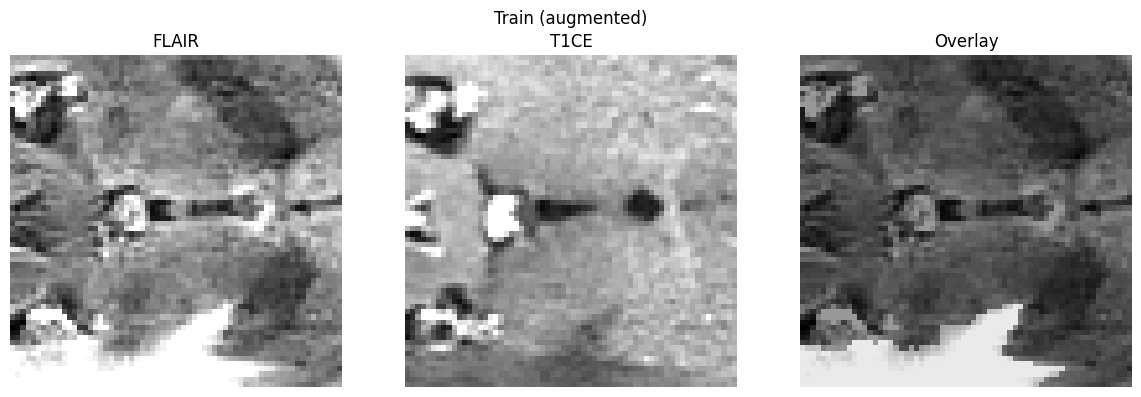

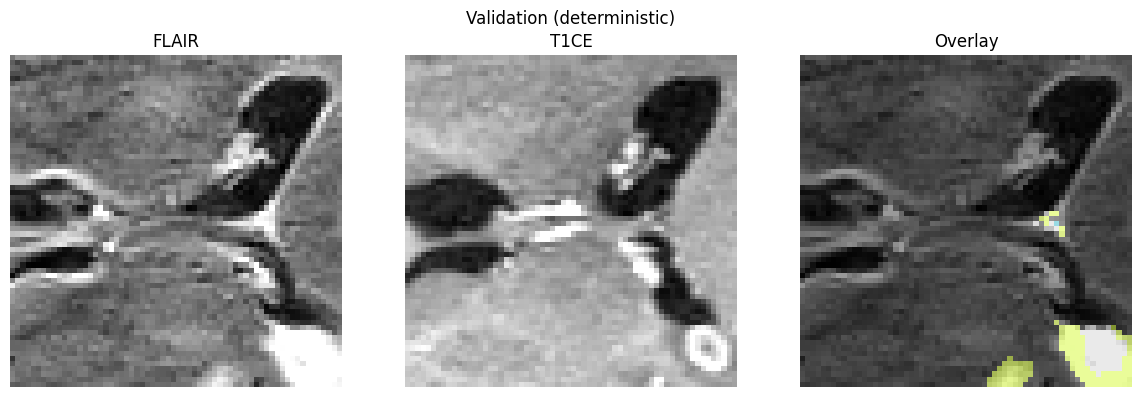

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def show_inline_center_slice(batch, title=""):
    flair = batch["flair"][0, 0].cpu().numpy()
    t1ce  = batch["t1ce"][0, 0].cpu().numpy()
    seg   = batch["seg"][0, 0].cpu().numpy().astype(np.int32)
    z = flair.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(flair[:, :, z], cmap="gray"); axs[0].set_title("FLAIR"); axs[0].axis("off")
    axs[1].imshow(t1ce[:, :, z],  cmap="gray"); axs[1].set_title("T1CE");  axs[1].axis("off")
    axs[2].imshow(flair[:, :, z], cmap="gray")
    axs[2].imshow(seg[:, :, z], cmap="nipy_spectral", alpha=0.4, interpolation="nearest")
    axs[2].set_title("Overlay"); axs[2].axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

# Show 1 augmented train and 1 val sample
tb = next(iter(train_loader)); show_inline_center_slice(tb, "Train (augmented)")
if val_loader is not None:
    vb = next(iter(val_loader)); show_inline_center_slice(vb, "Validation (deterministic)")

In [50]:
# GPU 3D MONAI pipeline with auto-ROI selection (targets ~15 GiB VRAM)
# - Simple augs: Flip + mild ScaleIntensity (no noise to avoid blur)
# - Label fix: 4 -> 3
# - Auto-tries ROI from largest to smaller until a warmup forward works
# - AMP on, Val every epoch, early stopping, saves best_3d_unet.pth

import os, glob, random, numpy as np, torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    ScaleIntensityRangePercentilesd,
    CropForegroundd, SpatialPadd, CenterSpatialCropd,
    RandFlipd, RandScaleIntensityd,
    MapLabelValued, EnsureTyped
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

# ================== CONFIG ==================
# Basic seeding (do not touch CUDA RNG)
seed = 42
random.seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "GPU not detected. Go to runtime settings and enable GPU, then re-run."

DATA_ROOT = "data"           # adjust if needed
IMG_KEYS  = ["flair", "t1ce"]
ALL_KEYS  = IMG_KEYS + ["seg"]

# ROI candidates from largest to smaller; we will auto-select the biggest that fits
ROI_CANDIDATES = [(112,112,112), (96,96,96), (80,80,80), (64,64,64)]

MAX_TRAIN_CASES = 40
MAX_VAL_CASES   = 10

DL_NUM_WORKERS = 2
DL_PIN_MEMORY  = True
DL_PERSISTENT  = True

UNET_CHANNELS = (16, 32, 64, 128)  # fits 15 GiB with ROI <= 96^3; auto-fallback handles larger ROI
UNET_STRIDES  = (2, 2, 2)
MAX_EPOCHS    = 20
PATIENCE      = 6
OVERLAP       = 0.25  # inference overlap (lower reduces VRAM)

# ================== HELPERS ==================
def build_case_list(root: str):
    flairs = glob.glob(os.path.join(root, "**", "*_flair.nii.gz"), recursive=True)
    flairs += glob.glob(os.path.join(root, "**", "*_flair.nii"), recursive=True)
    cases = []
    for fpath in sorted(flairs):
        d = os.path.dirname(fpath)
        base = os.path.basename(d)
        t1ce = os.path.join(d, f"{base}_t1ce.nii.gz")
        if not os.path.exists(t1ce): t1ce = os.path.join(d, f"{base}_t1ce.nii")
        seg  = os.path.join(d, f"{base}_seg.nii.gz")
        if not os.path.exists(seg):  seg  = os.path.join(d, f"{base}_seg.nii")
        if os.path.exists(t1ce) and os.path.exists(seg):
            cases.append({"flair": fpath, "t1ce": t1ce, "seg": seg})
    return cases

def make_transforms(roi_size):
    # Label 4 -> 3 (BraTS)
    label_remap = MapLabelValued(keys="seg", orig_labels=[4], target_labels=[3])
    # Percentile windowing for stable intensities (clean visuals, robust for training)
    intensity_window = ScaleIntensityRangePercentilesd(
        keys=IMG_KEYS, lower=0.5, upper=99.5, b_min=0.0, b_max=1.0, clip=True
    )
    train_tf = Compose([
        LoadImaged(keys=ALL_KEYS),
        EnsureChannelFirstd(keys=ALL_KEYS),
        intensity_window,
        CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
        SpatialPadd(keys=ALL_KEYS, spatial_size=roi_size),
        CenterSpatialCropd(keys=ALL_KEYS, roi_size=roi_size),
        label_remap,
        # Simple, safe augmentations:
        RandFlipd(keys=ALL_KEYS, prob=0.30, spatial_axis=[0,1,2]),
        RandScaleIntensityd(keys=IMG_KEYS, factors=0.05, prob=0.10),  # mild ±5% scale
        EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
        EnsureTyped(keys="seg", dtype=torch.long),
    ])
    val_tf = Compose([
        LoadImaged(keys=ALL_KEYS),
        EnsureChannelFirstd(keys=ALL_KEYS),
        intensity_window,
        CropForegroundd(keys=ALL_KEYS, source_key="flair", margin=8),
        SpatialPadd(keys=ALL_KEYS, spatial_size=roi_size),
        CenterSpatialCropd(keys=ALL_KEYS, roi_size=roi_size),
        label_remap,
        EnsureTyped(keys=IMG_KEYS, dtype=torch.float32),
        EnsureTyped(keys="seg", dtype=torch.long),
    ])
    return train_tf, val_tf

def build_loaders(train_files, val_files, train_tf, val_tf):
    train_ds = Dataset(train_files, transform=train_tf)
    train_loader = DataLoader(
        train_ds, batch_size=1, shuffle=True,
        num_workers=DL_NUM_WORKERS, pin_memory=DL_PIN_MEMORY, persistent_workers=DL_PERSISTENT
    )
    val_loader = None
    if len(val_files) > 0:
        val_ds = Dataset(val_files, transform=val_tf)
        val_loader = DataLoader(
            val_ds, batch_size=1, shuffle=False,
            num_workers=DL_NUM_WORKERS, pin_memory=DL_PIN_MEMORY, persistent_workers=DL_PERSISTENT
        )
    return train_loader, val_loader

def build_model():
    return UNet(
        spatial_dims=3,
        in_channels=2,
        out_channels=4,     # labels {0,1,2,3} after 4->3 remap
        channels=UNET_CHANNELS,
        strides=UNET_STRIDES,
        num_res_units=2,
    ).to(device)

def warmup_forward(model, loader):
    # One tiny forward to check VRAM footprint
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        batch = next(iter(loader))
        imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device, non_blocking=True)
        _ = model(imgs)

# ================== DATA DISCOVERY ==================
all_cases = build_case_list(DATA_ROOT)
assert len(all_cases) > 0, f"No cases found under '{DATA_ROOT}'"
train_files = all_cases[:MAX_TRAIN_CASES]
val_files   = all_cases[MAX_TRAIN_CASES:MAX_TRAIN_CASES + MAX_VAL_CASES]
print(f"Cases | Train: {len(train_files)} | Val: {len(val_files)}")

# ================== AUTO-ROI SELECTION ==================
selected_roi = None
for roi in ROI_CANDIDATES:
    try:
        print(f"Trying ROI {roi} ...", flush=True)
        train_tf, val_tf = make_transforms(roi)
        train_loader, val_loader = build_loaders(train_files, val_files, train_tf, val_tf)
        model = build_model()
        warmup_forward(model, train_loader)  # may OOM here
        selected_roi = roi
        print(f"Selected ROI: {selected_roi}")
        break
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"OOM with ROI {roi}. Clearing CUDA cache and trying smaller ROI...")
            del model
            torch.cuda.empty_cache()
            continue
        else:
            raise

assert selected_roi is not None, "All ROI candidates OOM. Reduce UNET_CHANNELS or try smaller ROIs."

# ================== TRAINING SETUP ==================
optimizer   = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
loss_fn     = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")
scaler      = torch.cuda.amp.GradScaler()

def voxel_accuracy(logits, targets):
    with torch.no_grad():
        pred = logits.argmax(dim=1, keepdim=True)
        return (pred == targets).float().mean().item()

# ================== TRAIN LOOP ==================
best_dice  = 0.0
bad_epochs = 0

print(f"Device: {device} | Using AMP: True | ROI: {selected_roi} | Model channels: {UNET_CHANNELS}")

for epoch in range(1, MAX_EPOCHS + 1):
    # Train
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device, non_blocking=True)
        seg  = batch["seg"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss = loss_fn(logits, seg)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))

    # Validate
    val_dice = 0.0
    val_acc  = 0.0
    if val_loader is not None and len(val_loader) > 0:
        model.eval()
        dice_metric.reset()
        acc_sum, n = 0.0, 0
        with torch.no_grad(), torch.cuda.amp.autocast():
            for batch in val_loader:
                imgs = torch.cat([batch["flair"], batch["t1ce"]], dim=1).to(device, non_blocking=True)
                seg  = batch["seg"].to(device, non_blocking=True)
                pred = sliding_window_inference(imgs, roi_size=selected_roi, sw_batch_size=1, predictor=model, overlap=OVERLAP)
                dice_metric(y_pred=torch.softmax(pred, dim=1), y=seg)
                acc_sum += voxel_accuracy(pred, seg)
                n += 1
        val_dice = dice_metric.aggregate().item()
        val_acc  = acc_sum / max(1, n)

    print(f"Epoch {epoch:02d} | TrainLoss {avg_loss:.4f} | ValDice {val_dice:.4f} | ValAcc {val_acc:.4f}")

    improved = (val_loader is not None and val_dice > best_dice) or (val_loader is None and epoch == 1)
    if improved:
        best_dice = max(best_dice, val_dice)
        bad_epochs = 0
        torch.save(model.state_dict(), "best_3d_unet.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("Early stopping.")
            break

print(f"Done. Best Val Dice: {best_dice:.4f}")
print("Best model saved to best_3d_unet.pth")

Cases | Train: 40 | Val: 10
Trying ROI (112, 112, 112) ...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
